# <center>Анализ алгоритма<a style='color:red'> MTCNN </a> 
#### <center><a style='color:red'> Multi-task Cascaded Convolutional Networks </a> 

___
<a id=100>Содержание</a>
- [Ключевые особенности алгоритма](#1)
- [Основные этапы алгоритма](#2)
    - [Предобработка изображений](#3)
    - [P-Net](#4)
    - [R-Net](#5)
    - [O-Net](#6)
- [Пример использования](#7)
- [Преимущества и недостатки MTCNN](#8)
- [Использованные источники](#9)

___
## <center><a id=1 style='color:red'>Ключевые особенности алгоритма</a>

`MTCNN` (Multi-task Cascaded Convolutional Networks) - это каскадная искусственная нейронная сеть для детекции лиц, которая состоит из трех основных, последовательно работающих, сверточных нейронных сетей: `P-Net`, `R-Net` и `O-Net`.

$\boxed{1}$ `P-Net` (Proposal Network) сканирует входное изображение, предсказывает координаты рамок и вероятности наличия лица в каждой рамке.

$\boxed{2}$ `R-Net` (Refinement Network) уточняет детекции лиц в рамках, полученные от предыдущего этапа - P-Net. 

$\boxed{3}$ `O-Net` (Output Network) обнаруживает ключевые точки обнаруженного лица (глаза, нос, уголки губ), детектированного на предыдущем этапе - R-Net

MTCNN является одной из наиболее точных и широко используемых нейронных сетей для детекции лиц, котороая показывает хорошие результаты при различных масштабах лиц, различными углами и условиями освещения.


___
## <center><a id=2 style='color:red'>Основные этапы алгоритма</a>


### <center><a id=3 >1. Предобработка изображений</a>

Перед подачей исходного изображения в первую нейронную сеть каскада (P-Net), применяется метод `"пирамиды изображений"`, который заключается в создании нескольких версий одного и того же изображения разного размера. Этот подход помогает решить следующие задачи:
- `Уменьшение вычислительной нагрузки`.  
Изображения могут быть большого размера,а уменьшение размера перед подачей на вход нейронной сети позволяет уменьшить количество операций, которые необходимо выполнить для анализа изображения.
- `Улучшение скорости обнаружения лиц`.  
Меньшие изображения требуют меньше времени для обработки нейронной сетью, что может быть особенно важно при работе в реальном времени, где скорость обнаружения лиц играет ключевую роль.
- `Улучшение обобщающей способности модели`.  
Изменение размера изображения до стандартного значения может улучшить обобщающую способность модели, что решает задачу предотвращения переобучение на конкретных деталях изображений большого размера и делает модель более устойчивой к различным размерам искомых объектов, что помогает обнаруживать как мелкие масштабы лиц, так и крупные.

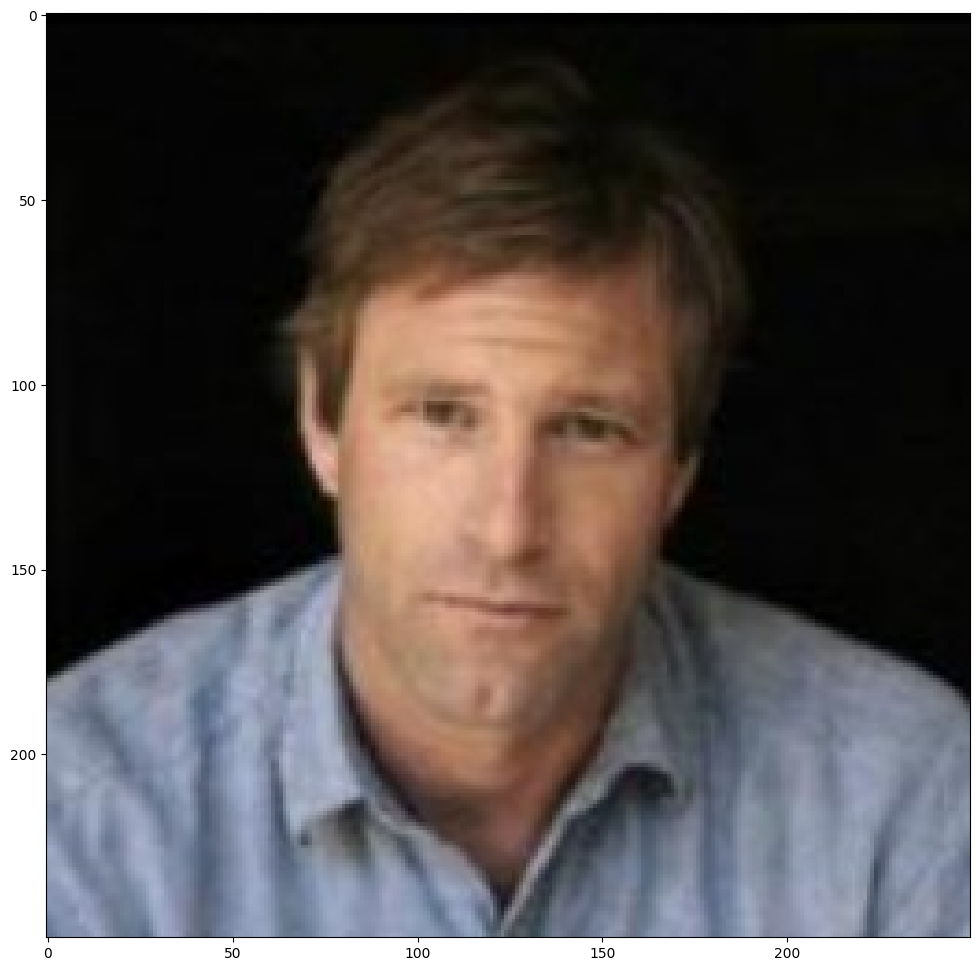

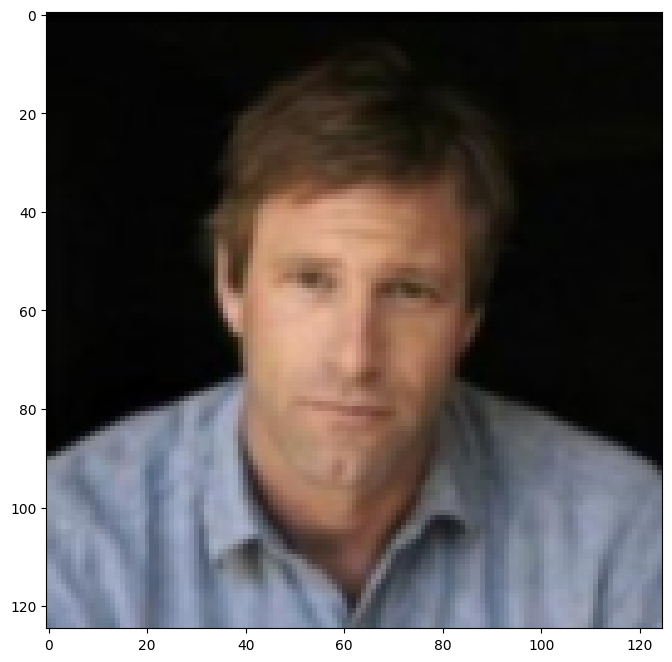

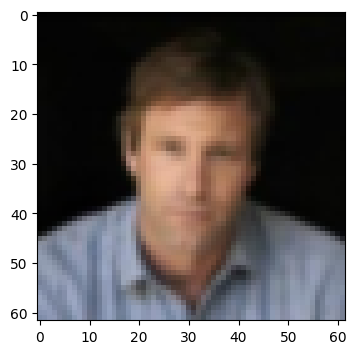

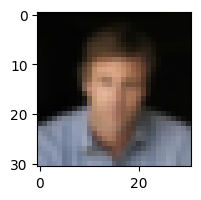

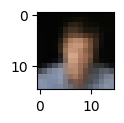

In [75]:
import cv2
import matplotlib.pyplot as plt


img = cv2.imread('data/Aaron_Eckhart/Aaron_Eckhart_0001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rows, cols, rgb = img.shape
fig = plt.figure(0, figsize=(rows // 20, cols // 20))
plt.imshow(img)

for i in range(1, 5):
    lower_reso = cv2.pyrDown(img, dstsize=(rows // 2, cols // 2))
    rows, cols, rgb = lower_reso.shape
    img = lower_reso
    fig = plt.figure(i, figsize=(rows // 15, cols // 15))
    plt.imshow(img)

### <center><a id=4 >2. P-Net</a>

Экземпляры разного размера исходного изображения подаются на вход первой нейронной сети - P-Net. P-Net (Proposal Network) - сверточная нейрнонная сеть, которая отвечает за `грубую оценку местоположения лица` на входном изображении и генерирует набор кандидатов (proposal boxes), которые затем подаются на следующий этап сети для более точного обнаружения и выравнивания лиц.

<center><a>Алгоритм работы P-Net</a></center>

- <a id='conv'>Сверточный слой</a> извлекает признаки из входных изображений. Сверточный слой состоит из слоев свертки, функций активаций ReLu, пулинг слоя.
    - `Слои свертки` применяют различные фильтры для извлечения таких признаков на изображениях, как грани, текстуры, формы. Последовательно применяются свертки с количеством фильтров: 10 ,16, 32, размером 3х3 и шагом 1.
    - `Функция активации ReLu` применяется после каждого слоя свертки, которая переводит признаки в нелинейное пространство.  
    
    $\boxed{ReLu = \max{(0, x)}}$  
    График $ReLu$:  
    <img src='data/img/relu.webp' width=300></img>
    
    - `Макс пулинг слой` с размером окна 2х2 и шагом 2 уменьшает размер признакового пространства и снижает вычислительную сложность модели, путем выбора наибольшего значения признака, попавшего в окно.

- <a id='det'>Выходной слой</a>  имеет два параллельных выхода: классификационный, для предсказания вероятности обнаружения лиц на изображении и выход координат контура, отвечающий за вывод координат прямоугольного контура вокруг лица:
    - `Выход классификации` использует функцию потерь **cross-entropy** для предсказания вероятности (уверенности) того, что в данной области изображения находится лицо.
    
    - $\boxed{L_i^{conf} = - \Bigg( y_i^{conf} \cdot \log(p_i) + \Big(1 - y_i^{conf}\Big) \cdot \Big(1 -  \log(p_i)\Big)\Bigg) }$, где:
    
        - $y_i^{conf}$ - истинное значение, является ли $i$-объект лицом
        - $p_i$ - вероятность, выданная нейронной сетью, является ли $i$-объект лицом
        - $y_i^{conf} \in \{0,1\}$
    
    - `Выход координат контура` использует линейные слои и **L2-функцию потерь** для предсказания координат верхненго левого угла, ширины и высоты ограничивающего прямоугольного контура лица.  
    $\boxed{L_i^{box} = \Big|\Big| \hat{y}_i^{box}  - y_i^{box}\Big|\Big|^2_2 }$, где:
        - $y_i^{box}$ - истинное значение координат ограничивающего контура лица
        - $\hat{y}_i^{box}$ - координаты, выданные нейронной сетью
        - $y_i^{box} \in R^4$

- <a id='nms'>Этап Non-Maximum Suppression</a> удаляет прямоугольные контуры лиц, которые дублируются и накладываются друг на друга, что увеличивает точность обнаружения лиц и уменьшает количество ложных детекций. Алгоритм:
    - Вычисляется `IoU (Intersection over Union)` для каждого, полученного из выхода координат контура. IoU представляет собой отношение площади пересечения двух областей к площади их объединения:
        - $\boxed{ IoU = \frac{(A ∩ B)}{(A ∪ B)} } $
        
        <img src='data/img/iou.webp' width=300></img> 
    - Контуры `сортируются` по значению вероятности детекции лица внутри контура, полученной из выхода классификации.
    - Для каждого отсортированного контура:
        - Контур с наибольшей вероятностью принимается как самый лучший и `удаляются` все контуры, у которых IoU с текущим контуром более, чем `пороговое значение` (как правило, 0.5).
        - Текущий лучший контур добавляется в итоговый массив `лучших контуров`.

    Контуры выходного слоя:

    <img src='data/img/NMS.png' width=300></img> 
    
    Контуры после Non-Maximum Suppression:
    
    <img src='data/img/NMS2.png' width=300></img> 

<center><a>Архитектура P-Net</a></center>

Схема архитектуры P-Net:

<img src='data/img/pnet.png' width=500>

Реализация в Pytorch:

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torchsummary


class PNet(nn.Module):

    def __init__(self):
        super(PNet, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  
            nn.MaxPool2d(kernel_size=2, stride=2),  # pool1
            nn.Conv2d(10, 16, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  
            nn.Conv2d(16, 32, kernel_size=3, stride=1),  # conv3
            nn.PReLU()  
        )

        self.conv4_1 = nn.Conv2d(32, 2, kernel_size=1, stride=1)
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1)

    def forward(self, x):
    
        x = self.conv_layer(x)

        confidence = F.softmax(self.conv4_1(x), dim=1)
        box_coords = self.conv4_2(x)
        landmarks = self.conv4_3(x)

        return confidence, box_coords
    
model = PNet().to('cuda:0')
torchsummary.summary(model, ( 3, 12, 12))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 10, 10]             280
             PReLU-2           [-1, 10, 10, 10]               1
         MaxPool2d-3             [-1, 10, 5, 5]               0
            Conv2d-4             [-1, 16, 3, 3]           1,456
             PReLU-5             [-1, 16, 3, 3]               1
            Conv2d-6             [-1, 32, 1, 1]           4,640
             PReLU-7             [-1, 32, 1, 1]               1
            Conv2d-8              [-1, 2, 1, 1]              66
            Conv2d-9              [-1, 4, 1, 1]             132
           Conv2d-10             [-1, 10, 1, 1]             330
Total params: 6,907
Trainable params: 6,907
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total

### <center><a id=5 >3. R-Net</a>

Для уточнения детекции лиц, на следующем этапе после P-Net, применяется сверточная нейронная сеть R-Net, которая работает на более высоком разрешении изображения чем P-Net. На вход R-Net подаются откалиброванные контуры лиц с увеличенным разрешением 24 х 24.

<center><a>Алгоритм работы R-Net</a></center>

- [Сверточный слой](#conv) извлекает признаки из откалиброванных контуров лиц. Аналогично [P-Net](#4), сверточный слой R-Net состоит из слоев свертки, функций активаций ReLu, пулинг слоев. Отличия от P-Net:
- Для `слоев свертки`:
    - Увеличено количество фильтров: 28, 48, 64
    - Увеличен размер фильтров: 3х3, 2х2

- Для `слоев макс пулинга`:
    - Добавлен еще один слой макс пулинга
    - Увеличен размер окон: 3х3 

- [Выходной слой](#det), аналогично [P-Net](#4), имеет два параллельных выхода: классификационный, для предсказание вероятности обнаружения лиц на изображении и выход координат контура, отвечающий за вывод координат прямоугольного контура вокруг лица
- [Этап Non-Maximum Suppression](#nms), аналогично [P-Net](#4), удаляет прямоугольные контуры лиц, которые дублируются и накладываются друг на друга, что увеличивает точность обнаружения лиц и уменьшает количество ложных детекций.


<center><a>Архитектура R-Net</a></center>

Схема архитектуры R-Net:

<img src='data/img/rnet.png' width=500>

Реализация в Pytorch

In [23]:
class RNet(nn.Module):
    def __init__(self):
        super(RNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 28, kernel_size=3, stride=1),  # conv1
            nn.PReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),  # pool1
            nn.Conv2d(28, 48, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(48, 64, kernel_size=2, stride=1),  # conv3
            nn.PReLU()  

        )
        self.line1 = nn.Sequential(
            nn.Linear(64 * 3 * 3, 128),
            nn.PReLU()
        )

        self.line2_1 = nn.Linear(128, 1)
        self.line2_2 = nn.Linear(128, 4)
        self.line2_3 = nn.Linear(128, 10)

    def forward(self, x):

        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.line1(x)

        confidence = F.softmax(self.line2_1(x), dim=1)
        box_coords = self.line2_2(x)
        landmarks = self.line2_3(x)

        return confidence, box_coords, landmarks

model = RNet()
torchsummary.summary(model, ( 3, 24, 24))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 28, 22, 22]             784
             PReLU-2           [-1, 28, 22, 22]               1
         MaxPool2d-3           [-1, 28, 11, 11]               0
            Conv2d-4             [-1, 48, 9, 9]          12,144
             PReLU-5             [-1, 48, 9, 9]               1
         MaxPool2d-6             [-1, 48, 4, 4]               0
            Conv2d-7             [-1, 64, 3, 3]          12,352
             PReLU-8             [-1, 64, 3, 3]               1
            Linear-9                  [-1, 128]          73,856
            PReLU-10                  [-1, 128]               1
           Linear-11                    [-1, 1]             129
           Linear-12                    [-1, 4]             516
           Linear-13                   [-1, 10]           1,290
Total params: 101,075
Trainable params:

### <center><a id=6 >4. O-Net</a>

Входными данными для O-Net является область изображения, содержащая лицо, которое было детектировано и уточнено на предыдущем этапе - R-Net. Эта область имеет еще более высокое разрешение (48х48) и содержит лицо с более высоким уровнем детализации.

<center><a>Алгоритм работы O-Net</a></center>

- [Сверточный слой](#conv) извлекает признаки из откалиброванных контуров лиц. Аналогично [R-Net](#5), сверточный слой R-Net состоит из слоев свертки, функций активаций ReLu, пулинг слоев. Отличия от R-Net:
- Для `слоев свертки`:
    - Добавлен еще один сверточный слой
    - Увеличено количество фильтров: 32, 64, 128

- Для `слоев макс пулинга`:
    - Добавлен еще один слой макс пулинга

- [Выходной слой](#det), аналогично [R-Net](#4), имеет два параллельных выхода: `классификационный`, для предсказание вероятности обнаружения лиц на изображении и `выход координат контура`, отвечающий за вывод координат прямоугольного контура вокруг лица, а также выход координат ключевых точек лица, которые могут использоваться для различных задач, таких как распознавание эмоций, оценка возраста и пола и другие
    - `Выход ключевых точек лица` использует линейные слои и **L2-функцию потерь** для предсказания пяти ключевых точек лица: глаза, нос, уголки губ.  
    $\boxed{L2_i = \Big|\Big| \hat{y}_i^{land}  - y_i^{land}\Big|\Big|^2_2 }$, где:
        - $y_i^{land}$ - истинное значение координат ключевых точек лица
        - $\hat{y}_i^{land}$ - координаты ключевых точек, выданные нейронной сетью
        - $y_i^{land} \in R^{10}$

- [Этап Non-Maximum Suppression](#nms), аналогично [R-Net](#5), удаляет прямоугольные контуры лиц, которые дублируются и накладываются друг на друга, что увеличивает точность обнаружения лиц и уменьшает количество ложных детекций.


<center><a>Архитектура O-Net</a></center>

Схема архитектуры O-Net:

<img src='data/img/onet.png' width=500>

Реализация в Pytorch

In [32]:
class ONet(nn.Module):
    def __init__(self):

        super(ONet, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),  # pool1
            nn.Conv2d(32, 64, kernel_size=3, stride=1),  # conv2
            nn.PReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # conv3
            nn.PReLU(),  
            nn.MaxPool2d(kernel_size=2, stride=2),  # pool3
            nn.Conv2d(64, 128, kernel_size=2, stride=1),  # conv4
            nn.PReLU()  
        )
        self.line1 = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.PReLU() 
        )

        self.line2_1 = nn.Linear(256, 1)
        self.line2_2 = nn.Linear(256, 4)
        self.line2_3 = nn.Linear(256, 10)

    def forward(self, x):

        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.line1(x)

        confidence = F.softmax(self.line2_1(x), dim=1)
        box_coords = self.line2_2(x)
        landmarks = self.line2_3(x)

        return confidence, box_coords, landmarks

model = ONet()
torchsummary.summary(model, ( 3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             896
             PReLU-2           [-1, 32, 46, 46]               1
         MaxPool2d-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 22, 22]          18,496
             PReLU-5           [-1, 64, 22, 22]               1
         MaxPool2d-6           [-1, 64, 10, 10]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
             PReLU-8             [-1, 64, 8, 8]               1
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 3, 3]          32,896
            PReLU-11            [-1, 128, 3, 3]               1
           Linear-12                  [-1, 256]         295,168
            PReLU-13                  [-1, 256]               1
           Linear-14                   

___
## <center><a id=7 style='color:red'>Пример использования</a>

- `Загрузка изображения`

- `Инициализация MTCNN`

In [1]:
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('data/Aaron_Eckhart/Aaron_Eckhart_0001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 105ms/step


- `Отрисовка контура лица и ключевых точек`

In [2]:
from PIL import Image, ImageDraw

img = Image.open('data/Aaron_Eckhart/Aaron_Eckhart_0001.jpg')
img_detected = img.copy()
draw = ImageDraw.Draw(img_detected)

def get_box(results: list) -> list:
    x = results[0]['box'][0]
    y = results[0]['box'][1]
    width = x + results[0]['box'][2]
    higth = x + results[0]['box'][3]
    return [x, y, width, higth]

def draw_keypoints(results: list) -> None:
    draw.point(results[0]['keypoints']['left_eye'], fill=(255,0,0))
    draw.point(results[0]['keypoints']['right_eye'], fill=(255,0,0))
    draw.point(results[0]['keypoints']['nose'], fill=(255,0,0))
    draw.point(results[0]['keypoints']['mouth_left'], fill=(255,0,0))
    draw.point(results[0]['keypoints']['mouth_right'], fill=(255,0,0))

draw.rectangle(get_box(results), outline=(255,0,0))
draw_keypoints(results)

Text(0.5, 1.0, 'Confidence: 0.9999')

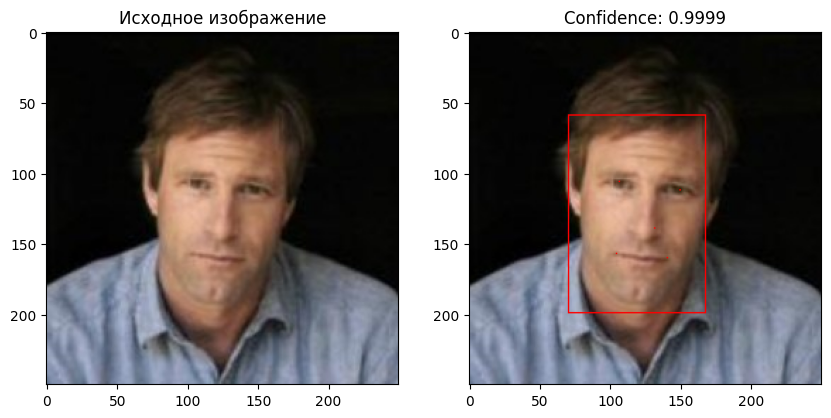

In [3]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img)
ax[1].imshow(img_detected)
ax[0].set_title('Исходное изображение')
ax[1].set_title(f'Confidence: {results[0]["confidence"]:.4f}')

___
## <center><a id=8 style='color:red'>Преимущества и недостатки MTCNN</a>

<center><a>Преимущества</a></center>

- `Высокая скорость` обнаружения лиц: MTCNN благодаря многоуровневой структуре обладает высокой скоростью обнаружения лиц в изображениях, что позволяет использовать его в реальном времени для детектирования лиц на видео или в потоковых данных.

- `Высокое качество` обнаружения лиц: MTCNN использует комбинацию различных сетей для обнаружения лиц, что позволяет ему точно определять лица на изображениях.
- `Масштабируемость`: MTCNN может быть использован для обнаружения лиц на изображениях с различным разрешением и в различных условиях освещения. Также может быть использован для детектирования не только лиц, но и других объектов на изображениях.


<center><a>Недостатки</a></center>

- `Высокая вычислительная сложность`: Использование трех различных нейронных сетей делает MTCNN требовательным к вычислительным ресурсам, что может быть проблемой при работе на устройствах с ограниченными вычислительными мощностями.

- `Ресурсоемкость`: Для работы MTCNN необходимо большое количество памяти и процессорного времени, что может быть проблематично для устройств с ограниченными ресурсами.
- `Требует большого количества обучающих данных`: Для обучения MTCNN необходимо большое количество размеченных данных, что может быть сложной задачей для реализации.

___
## <center><a id=9 style='color:red'>Использованные источники</a>

| Ссылка|Краткое описание |
|-|-| 
| [Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks](https://kpzhang93.github.io/MTCNN_face_detection_alignment/paper/spl.pdf)| Описание алгоритма |
| [Алгоритм обнаружения ключевых точек лица-MTCNN](https://russianblogs.com/article/83851264065/)| Описание алгоритма|
| [Mtcnn pytorch implementation](https://www.programmersought.com/article/4588466183/)|Имплементация MTCNN при помощи библиотеки MTCNN_Pytorch  |
|[GitHub TropComplique](https://github.com/TropComplique/mtcnn-pytorch/tree/master) |Имплементация и описание алгоритма |
| [GitHub preprocessing-images-for-Face-Recognition](https://github.com/Emma0118/preprocessing-images-for-Face-Recognition/tree/master/preprocessing-images-for-Face-Recognition)| Имплементация и описание алгоритма|
|[MTCNN face detection full process detailed explanation pytorch code](https://www.programmersought.com/article/93437488980/) | Имплементация и описание алгоритма|
| [GitHub ysf465639310](https://github.com/ysf465639310/PYTORCH_MTCNN/tree/master)| Имплементация алгоритма|
| [Face detection: MTCNN face detection detection training](https://www.programmersought.com/article/31174385430/)| Описание предобработки и P-net|
|[Наглядно о том, как работает свёрточная нейронная сеть (Хабр)](https://habr.com/ru/companies/skillfactory/articles/565232/) | Описание алгоритма сверточной нейронной сети|
|[Свёрточная нейронная сеть с нуля. Часть 0. Введение](https://programforyou.ru/poleznoe/convolutional-network-from-scratch-part-zero-introduction) | Описание сверточных НС|
